In [75]:
import numpy as np
import matplotlib.pyplot as plt 
from minisom import MiniSom    

(1000, 3)
Star ID:  0.0 , lat: 66.96904212756476 , len:  295.85216510291696
Star ID:  1.0 , lat: 214.68535173999615 , len:  202.45402304952592
Star ID:  2.0 , lat: 241.23276943443503 , len:  100.03922324111622
Star ID:  3.0 , lat: 108.9040508227288 , len:  53.968555307730554
Star ID:  4.0 , lat: 306.9172542622873 , len:  337.56273301481656


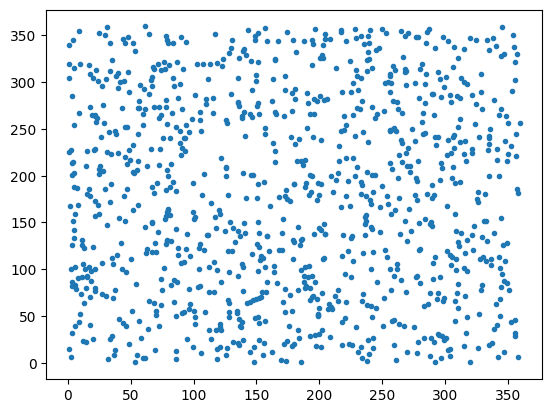

In [88]:
#  Create a set of random stars in range [360,360]
n_stars = 1000

# Create the set of points
x = np.random.uniform(0, 360, n_stars)
y = np.random.uniform(0, 360, n_stars)
stars_id = np.linspace(0,n_stars-1,n_stars, dtype=int)

stars_data = np.array( np.transpose([x,y, stars_id]))

print(stars_data.shape)

for i in range(5):
    print("Star ID: ", stars_data[i][2], ", lat:", stars_data[i][0], ", len: ", stars_data[i][1])

plt.figure()
plt.plot(x,y,'.')
plt.show()

In [95]:
from scipy.spatial import KDTree

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed 
tree = KDTree(stars_data[:,:2])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features 

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,:2], k=n_of_neighbor+1)

features_vec = []

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][2], "(","%0.2f" % stars_data[i][0],",","%0.2f" %stars_data[i][1],")")
    features = []
    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        x_distance = stars_data[neighbor_index][0] - stars_data[i][0]
        y_distance = stars_data[neighbor_index][1] - stars_data[i][1]
        print("Neighbor ID:", stars_data[neighbor_index][2], "(","%0.2f" %stars_data[neighbor_index][0],",","%0.2f" %stars_data[neighbor_index][1],")", ", x-distance:", x_distance, ", y-distance:", y_distance)
        
        #  Define the features vector that is going to be used in the SOM:
        # TODO: Try diferent combinations of features to set the most efective one 

        # features = [ x1-x2, y1-y2, x1-x3, y1-y3, ..., x1-x_n, y1-y_n]
        features.append(x_distance)
        features.append(y_distance)

        # fetaures = [ r1 * r2, r1*r3, r1*r_n]
        # features.append(np.array(stars_data[neighbor_index][0] * stars_data[i][0] 
                        # + stars_data[neighbor_index][1] * stars_data[i][1]) )
        
        # Iter neighbor features 
        # features = [ x2-x3, y2-y3, x2-x4, y2-y4, ..., x_m-x_n, y_m-y_n]
        for k in range(1,n_of_neighbor+1-j):
            features.append()


    print("Number of features: ",len(features))
    features_vec.append(features)

Star ID: 0.0 ( 66.97 , 295.85 )
Neighbor ID: 963.0 ( 66.45 , 302.23 ) , x-distance: -0.5199999789018932 , y-distance: 6.380517331253316
Neighbor ID: 138.0 ( 60.26 , 293.00 ) , x-distance: -6.7131246693463495 , y-distance: -2.847845587975712
Neighbor ID: 295.0 ( 64.45 , 287.03 ) , x-distance: -2.5222467435899887 , y-distance: -8.825867858124411
Neighbor ID: 365.0 ( 66.95 , 305.28 ) , x-distance: -0.02088107194481381 , y-distance: 9.431960630437288
Number of features:  8
Star ID: 1.0 ( 214.69 , 202.45 )
Neighbor ID: 341.0 ( 209.34 , 199.46 ) , x-distance: -5.346943296762333 , y-distance: -2.9951456011386597
Neighbor ID: 536.0 ( 213.31 , 195.20 ) , x-distance: -1.3704329325126992 , y-distance: -7.251441768884149
Neighbor ID: 213.0 ( 222.46 , 194.17 ) , x-distance: 7.777498466016965 , y-distance: -8.283627551061556
Neighbor ID: 24.0 ( 215.97 , 216.22 ) , x-distance: 1.2815803031954829 , y-distance: 13.76220236366737
Number of features:  8
Star ID: 2.0 ( 241.23 , 100.04 )
Neighbor ID: 107.0

In [97]:
import numpy as np
from minisom import MiniSom

features_vec = np.array(features_vec) # Transform to array
star_features = features_vec

# Normalize the data -> better performace of the SOM 
star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))

# Define the SOM parameters

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
mesh_dim = np.int8(np.sqrt(features_vec.shape[0]))

som_rows = mesh_dim + 1 
som_columns = mesh_dim
input_len = star_features.shape[1]

# Initialize the SOM
#TODO optimize hiperparameters 
som = MiniSom(som_rows, som_columns, input_len, sigma=1.0, learning_rate=0.7, neighborhood_function='gaussian')
# Train the SOM
som.train_random(data=star_features_normalized, num_iteration=100000, verbose= True)


# Create a dictionary to store the star ID for each grid position
star_ids = {tuple(map(int, pos)): star_id for pos, star_id in zip(som.win_map(star_features_normalized), range(1, len(star_features_normalized+1) ))}


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.04782333641027148


In [91]:
# Check which features correspond to which neurons
som.win_map(star_features_normalized)


defaultdict(list,
            {(24,
              5): [array([0.4137784 , 0.66212301, 0.29548864, 0.41805544, 0.49466373,
                     0.2448068 , 0.5375704 , 0.68005037, 0.25260966, 0.48599411])],
             (6,
              31): [array([0.24328596, 0.34886657, 0.44871787, 0.29959316, 0.71302192,
                     0.25621423, 0.56642147, 0.76608914, 0.74071971, 0.41470983]), array([0.49829432, 0.34695673, 0.38210818, 0.22530759, 0.74939291,
                     0.27708635, 0.72718191, 0.66238082, 0.62891614, 0.64068246]), array([0.41052049, 0.37825043, 0.35225464, 0.37390698, 0.64142158,
                     0.29321768, 0.60047269, 0.67240246, 0.62567462, 0.37039796])],
             (31,
              8): [array([0.60849674, 0.        , 0.90689036, 0.49165598, 0.23912917,
                     0.61328396, 0.81236464, 0.74289612, 0.31541713, 0.77322663])],
             (19,
              3): [array([0.12329102, 0.49979792, 0.26322196, 0.34353191, 0.28997018,
              

In [98]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 
# TODO: Optimice this number via features selection,hp tuning, or other  
print("Number of neurons with data:", len(star_ids))

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
star_dict = {}
for i in range(len(star_features_normalized)):
    star_dict[som.winner(star_features_normalized[i])] = i+1

print("Number of neurons without data:", len(star_features_normalized)-len(star_dict))

Number of neurons with data: 765
Number of neurons without data: 235


Predicted Star ID: 350, actual star ID: 350


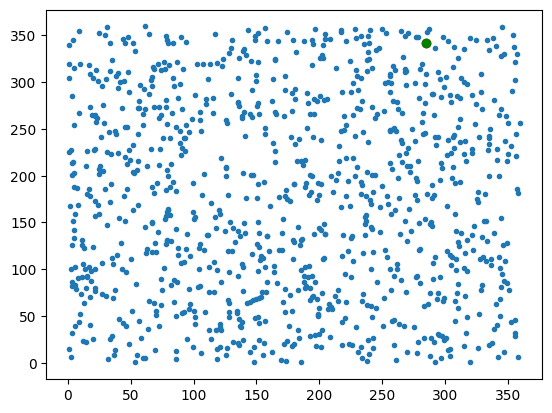

In [133]:
# Define a function to predict the star ID for a given feature vector
def predict_star_id(feature_vector, dictionary):
    normalized_feature = (feature_vector - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    winner = som.winner(normalized_feature)
    if winner in dictionary:
        return dictionary[winner]
    else:
        return 0
# Test the prediction for a sample feature vector
random_id = np.random.randint(1,features_vec.shape[0])
sample_feature_vector = features_vec[random_id-1] 

random_noise = np.random.normal(loc=0, scale=1.0, size=features_vec.shape[1])
sample_feature_vector = sample_feature_vector - random_noise

predicted_star_id = predict_star_id(sample_feature_vector,star_dict)

print(f"Predicted Star ID: {predicted_star_id}, actual star ID: {random_id}")

plt.figure()
plt.plot(x,y,'.')
plt.plot(stars_data[predicted_star_id][0],stars_data[predicted_star_id][1],'or')
plt.plot(stars_data[random_id][0],stars_data[random_id][1],'og')
plt.show()


In [132]:
cont = 0
for i in range(features_vec.shape[0]):
    sample_feature_vector = features_vec[i] 

    # Itroduce noise in the features vector to check the response of the SOM
    random_noise = np.random.normal(loc=0, scale=1.0, size=features_vec.shape[1])
    sample_feature_vector = sample_feature_vector - random_noise

    predicted_star_id = predict_star_id(sample_feature_vector,star_dict)
    if predicted_star_id == i +1: 
        cont = cont + 1 
print("total succes =",  cont / features_vec.shape[0],", succes over detected neurons =",  cont / len(star_ids))

total succes = 0.761 succes over detected neurons = 0.9947712418300654
